# DDPG for Solving Unity's "Reacher" Problem

In this notebook we report how we used **Deep Deterministic Policy Gradient (DDPG)** algorithm to solve a modified version of Unitfy's "Reacher" environment, where the agent needs to control a double-jointed arm to track a moving target in a 3D environment.

This notebook contains all the code for training and running the agent.

A demo of a trained agent is shown in the gif below:

![Demo](reacher-td3-demo.gif)

## Environment Setup

The dependencies can be set up by following the instructions from the [DRLND repo](https://github.com/udacity/deep-reinforcement-learning#dependencies). Once it's done, the following imports should work:

In [1]:
import collections
import copy
import itertools
import math
!pip install -q dataclasses
from dataclasses import dataclass
from typing import Any, List, Tuple, Optional, Generator
import random

import numpy
import torch
from unityagents import UnityEnvironment

import matplotlib.pyplot as plt
%matplotlib inline

Note that to make GPU training work on our machine, the following version of PyTorch is used:

In [2]:
print(f"Version: {torch.__version__}; Cuda available: {torch.cuda.is_available()}")

Version: 1.7.0+cu110; Cuda available: True


Additionally, we also need to download the pre-built Unity environment. There are 2 versions: the first version contains a single agent, while the second version contains 20 identical agents, each with its own copy of the environment. Here we'll be using **version 2** (more on this later), which can be downloaded for different platforms:

- Linux: [click here](https://s3-us-west-1.amazonaws.com/udacity-drlnd/P2/Reacher/Reacher_Linux.zip)
- Mac OSX: [click here](https://s3-us-west-1.amazonaws.com/udacity-drlnd/P2/Reacher/Reacher.app.zip)
- Windows (32-bit): [click here](https://s3-us-west-1.amazonaws.com/udacity-drlnd/P2/Reacher/Reacher_Windows_x86.zip)
- Windows (64-bit): [click here](https://s3-us-west-1.amazonaws.com/udacity-drlnd/P2/Reacher/Reacher_Windows_x86_64.zip)
    
Once downloaded and extracted, please set the path beolow according, e.g.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`

In [3]:
ENV_PATH = "../Reacher_Linux/Reacher.x86_64"

If set up correctly, we should be able to initialize the environment:

In [4]:
class ParallelEnv:
    def __init__(self):
        self._env = UnityEnvironment(file_name=ENV_PATH)
        
        env_info = self._env.reset(train_mode=True)[self._brain_name]
        self.num_agents = len(env_info.agents)
    
    @property
    def _brain_name(self):
        return self._env.brain_names[0]
    
    @property
    def _brain(self):
        return self._env.brains[self._brain_name]

    @property
    def action_dim(self) -> int:
        return self._brain.vector_action_space_size

    @property
    def action_scale(self) -> float:
        return 1.
    
    def sample_action(self) -> List[float]:
        return numpy.random.uniform(
            low=-self.action_scale,
            high=self.action_scale,
            size=(self.num_agents, self.action_dim)
        )

    @property
    def state_dim(self) -> int:
        return self._brain.vector_observation_space_size

    def reset(self, train_mode=True):
        env_info = self._env.reset(train_mode=train_mode)[self._brain_name]
        return env_info.vector_observations

    def step(self, actions):
        assert len(actions) == self.num_agents
        env_info = self._env.step(actions)[self._brain_name]
        return (
            numpy.array(env_info.vector_observations, dtype=numpy.float32),
            numpy.array(env_info.rewards, dtype=numpy.float32),
            numpy.array(env_info.local_done, dtype=bool),
        )
    
    def close(self):
        self._env.close()


env = ParallelEnv()

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


### Environment description

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of the agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

The environment is considered "solved" when the agents get an average score of `+30` over 100 consecutive episodes, averaged over all parallel agents.

In [5]:
print(f'Number of agents: {env.num_agents}')
print(f'Action dimension: {env.action_dim}')
print(f'States dimension: {env.state_dim}')

Number of agents: 20
Action dimension: 4
States dimension: 33


## Methodology & Implementation

To solve this toy problem, we experimented with DDPG as described by Lillicrap et al. (2015). Additionally, we also incorporated all extensions from the **Twin Delayed DDPG (TD3)** algorithm as described by Fujimoto et al. (2018), namely:
- **Clipped double Q-Learning for actor-critic**
- **Delayed policy updates**
- **Target policy smoothing regularization**

TD3 also uses the first 10,000 steps for "pure exploration", during which actions are uniformly sampled from the action space. We find it unnecessary for this particular problem (but for the optional [Crawler](https://github.com/udacity/deep-reinforcement-learning/blob/master/p2_continuous-control/Crawler.ipynb) problem it does seem necessary).

We also used **Prioritized experience replay**, which is also used by **Distributed Distributional DDPG (D4PG)** as described by Barth-Maron (2018). We also tried using the N-step returns as in D4PG, but it didn't seem to help. (For the Crawler environment, it does help with training progress initially but unfortunately slows it down later.)

More details and code are presented below.

### Hyper-parameters

The hyper-parameters we used is shown as the default values in the following data class:

In [6]:
@dataclass
class AgentConfig:
    replay_buffer_size: int = 100_000
    critic_lr: float = 1e-4
    actor_lr: float = 1e-4
    batch_size: int = 256
    policy_noise: float = 0.2
    policy_noise_clip: float = 0.5
    policy_update_freq: int = 2
    discount_factor: float = 0.99
    soft_update_factor: float = 0.005
    pure_exploration_steps: int = 0

AgentConfig()

AgentConfig(replay_buffer_size=100000, critic_lr=0.0001, actor_lr=0.0001, batch_size=256, policy_noise=0.2, policy_noise_clip=0.5, policy_update_freq=2, discount_factor=0.99, soft_update_factor=0.005, pure_exploration_steps=0)

### Prioritized experience replay

Here we use prioritized experience replay as described in Schaul et al. (2015). Specifically, we implemented the proportional priorization variant with the sum-tree data structure.

The code for the replay buffer is as follows:

In [7]:
class ProportionallyPrioritizedReplayBuffer:
    """A proportionally prioritized replay buffer implemented with sum-tree."""

    _curr_index: int
    _size: int
    _max_priority: float
    _sum_tree: List[float]
    _priorities: List[float]
    _samples: List[Any]

    def __init__(self, buffer_size: int):
        assert buffer_size > 1
        self._curr_index = 0
        self._size = 0
        self._max_priority = 1.0
        self._sum_tree = [0] * (2 ** (math.floor(math.log2(buffer_size - 1)) + 1) - 1)
        self._priorities = [0] * buffer_size
        self._samples = [None] * buffer_size

    def _ancestor_indices(self, sample_index: int) -> Generator[int, None, None]:
        assert 0 <= sample_index <= len(self._samples)
        index = sample_index + len(self._sum_tree)
        while index > 0:
            index = (index - 1) // 2
            yield index

    @staticmethod
    def _children_indices(index: int) -> Tuple[int, int]:
        # Note that it could go out-of-bounds for the sum tree array
        left_index = index * 2 + 1
        right_index = left_index + 1
        return left_index, right_index

    def _set_priority(self, sample_index: int, priority: float):
        assert priority > 0, "Weights must be non-negative"
        delta = priority - self._priorities[sample_index]
        self._priorities[sample_index] = priority
        for index in self._ancestor_indices(sample_index):
            self._sum_tree[index] += delta

        self._max_priority = max(self._max_priority, priority)

    def _set_sample(self, sample_index: int, sample: Any, priority: float):
        self._set_priority(sample_index, priority)
        self._samples[sample_index] = sample

    class _SampleHandle:
        _parent: "ProportionallyPrioritizedReplayBuffer"
        _index: int

        def __init__(self, parent: "ProportionallyPrioritizedReplayBuffer", index: int):
            assert 0 <= index <= len(parent._samples)
            self._parent = parent
            self._index = index

        @property
        def value(self) -> Any:
            return self._parent._samples[self._index]

        @property
        def priority(self) -> float:
            return self._parent._priorities[self._index]

        @priority.setter
        def priority(self, priority: float):
            self._parent._set_priority(self._index, priority)

        def reset(self, value: Any, priority: float):
            self._parent._set_sample(self._index, value, priority)

    def add(self, value: Any, priority: Optional[float] = None):
        """Add a new sample."""
        if priority is None:
            priority = self._max_priority

        self._SampleHandle(self, self._curr_index).reset(value, priority)

        buffer_size = len(self._samples)
        self._curr_index = (self._curr_index + 1) % buffer_size
        self._size = min(self._size + 1, buffer_size)

    @property
    def priority_sum(self):
        return self._sum_tree[0]

    @property
    def max_priority(self):
        return self._max_priority

    def sample_single(self, query: Optional[float] = None) -> _SampleHandle:
        """Draw a sample."""
        assert self.priority_sum > 0.0, "Nothing has been added"

        if query is None:
            query = random.random()

        assert 0.0 <= query <= 1.0
        target = self.priority_sum * query
        index = 0
        while True:
            assert 0.0 <= target <= self._sum_tree[index]
            index_l, index_r = self._children_indices(index)
            assert (index_l < len(self._sum_tree)) == (index_r < len(self._sum_tree))
            if index_l >= len(self._sum_tree):
                index_l -= len(self._sum_tree)
                index_r -= len(self._sum_tree)
                break

            sum_l = self._sum_tree[index_l]
            if target <= sum_l:
                index = index_l
            else:
                target -= sum_l
                index = index_r

        assert index_l < len(self._priorities)
        if target <= self._priorities[index_l]:
            index = index_l
        else:
            assert index_r < len(self._priorities)
            index = index_r

        return self._SampleHandle(self, index)

    def sample_batch(self, batch_size: int) -> List[_SampleHandle]:
        """Draw a stratified batch of samples with the given size."""
        end_points = numpy.linspace(0.0, 1.0, batch_size + 1).tolist()
        return [
            self.sample_single(query=numpy.random.uniform(l, r))
            for l, r in zip(end_points[:-1], end_points[1:])
        ]

    def __len__(self):
        """Return the current size of internal memory."""
        return self._size

### Actor-critics

Like in TD3, we also use two hidden layers of size 256, and let the critic take both state and action as the input of the first layer.

In [8]:
class ActorNet(torch.nn.Module):
    def __init__(
        self,
        state_dim: int,
        action_dim: int,
        action_scale=1.0,
        hidden_dims: Tuple[int, ...] = (256, 256),
    ):
        super().__init__()
        self.action_scale = action_scale
        self.fcs = torch.nn.ModuleList(
            [
                torch.nn.Linear(in_size, out_size)
                for in_size, out_size in zip(
                    (state_dim,) + hidden_dims, hidden_dims + (action_dim,)
                )
            ]
        )

    def forward(self, state):
        x = state
        for i, fc in enumerate(self.fcs, start=1):
            x = fc(x)
            if i != len(self.fcs):
                x = torch.relu(x)

        x = torch.tanh(x) * self.action_scale
        return x


class CriticNet(torch.nn.Module):
    def __init__(
        self,
        state_dim: int,
        action_dim: int,
        hidden_dims: Tuple[int, ...] = (256, 256),
    ):
        super().__init__()
        self.fcs = torch.nn.ModuleList(
            [
                torch.nn.Linear(in_size, out_size)
                for in_size, out_size in zip(
                    (state_dim + action_dim,) + hidden_dims, hidden_dims + (1,)
                )
            ]
        )

    def forward(self, state, action):
        x = torch.cat([state, action], dim=1)
        for i, fc in enumerate(self.fcs, start=1):
            x = fc(x)
            if i != len(self.fcs):
                x = torch.relu(x)

        return x

### Agent Implementation

To put it together, the agent implemented below.

In [9]:
class Agent:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    env: ParallelEnv
    config: AgentConfig

    replay_buffer: ProportionallyPrioritizedReplayBuffer

    critics_local: Tuple[CriticNet, CriticNet]
    critics_target: Tuple[CriticNet, CriticNet]
    actor_local: ActorNet
    actor_target: ActorNet

    critic_optimizer: torch.optim.Optimizer
    actor_optimizer: torch.optim.Optimizer

    t_step: int
        
    def __init__(
        self,
        env: ParallelEnv,
        config: Optional[AgentConfig] = None,
    ):
        self.env = env
        self.config = config or AgentConfig()

        self.replay_buffer = ProportionallyPrioritizedReplayBuffer(
            self.config.replay_buffer_size
        )
        self.critics_local = (
            CriticNet(env.state_dim, env.action_dim).to(self.device),
            CriticNet(env.state_dim, env.action_dim).to(self.device),
        )
        self.actor_local = ActorNet(
            env.state_dim, env.action_dim, action_scale=env.action_scale
        ).to(self.device)
        self.critics_target = copy.deepcopy(self.critics_local)
        self.actor_target = copy.deepcopy(self.actor_local)
        for m in itertools.chain(self.critics_target, [self.actor_target]):
            m.eval()

        self.critic_optimizer = torch.optim.Adam(
            itertools.chain(
                self.critics_local[0].parameters(),
                self.critics_local[1].parameters(),
            ),
            lr=self.config.critic_lr,
        )
        self.actor_optimizer = torch.optim.Adam(
            self.actor_local.parameters(),
            lr=self.config.actor_lr,
        )

        self.t_step = 0

    def act(self, state_batch):
        state_batch = torch.from_numpy(state_batch).float().to(self.device)
        self.actor_local.eval()
        with torch.no_grad():
            action_batch = self.actor_local(state_batch).cpu().numpy()
            
        self.actor_local.train()
        action_batch = action_batch.clip(
            min=-self.env.action_scale,
            max=self.env.action_scale,
        )
        return action_batch

    def reset(self):
        pass

    def learn(self):
        # Only start learning after the pure exploration phase has ended
        if self.t_step <= self.config.pure_exploration_steps:
            return
        
        if len(self.replay_buffer) < self.config.batch_size:
            return

        experiences = self.replay_buffer.sample_batch(self.config.batch_size)
        with torch.no_grad():
            states, actions, rewards, next_states, dones = [
                torch.from_numpy(numpy.vstack(v)).to(
                    dtype=torch.float, device=self.device
                )
                for v in zip(*[e.value for e in experiences])
            ]
            # Calculate importance sampling weights
            # (for simply not using alpha / beta here)
            sample_priorities = numpy.vstack([e.priority for e in experiences])
            sample_priorities = torch.from_numpy(sample_priorities).to(
                device=self.device, dtype=torch.float
            )
            sample_probs = sample_priorities / self.replay_buffer.priority_sum
            sample_weights = 1.0 / (sample_probs * len(self.replay_buffer))

            # Calculate target Q values
            next_actions = self.actor_target(next_states)
            next_actions = next_actions + torch.clamp(
                torch.randn_like(next_actions) * self.config.policy_noise,
                -self.config.policy_noise_clip,
                self.config.policy_noise_clip,
            )
            next_actions = torch.clamp(
                next_actions,
                -self.env.action_scale,
                self.env.action_scale,
            )
            y = rewards + (
                (1.0 - dones)
                * self.config.discount_factor
                * torch.min(
                    self.critics_target[0](next_states, next_actions),
                    self.critics_target[1](next_states, next_actions),
                )
            )

        # Update sampling priorities
        critic_losses = (
            sum(
                torch.nn.functional.mse_loss(
                    critic(states, actions),
                    y,
                    reduction="none"
                )
                for critic in self.critics_local
            )
        )
        with torch.no_grad():
            new_sample_priorities = critic_losses.sqrt().squeeze().cpu().numpy()
            assert len(experiences) == len(new_sample_priorities)
            for e, p in zip(experiences, new_sample_priorities):
                e.priority = p


        # Update local critics
        critic_loss = torch.mean(critic_losses * sample_weights)
        if torch.isnan(critic_loss).cpu().item():
            raise RuntimeError("NaN loss")

        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # Periodically update local actor as well as target networks
        if self.t_step % self.config.policy_update_freq == 0:
            # Update local actor
            actor_loss = -torch.mean(
                self.critics_local[0](states, self.actor_local(states))
            )
            if torch.isnan(actor_loss).cpu().item():
                raise RuntimeError("NaN loss")

            self.actor_optimizer.zero_grad()
            actor_loss.backward()
            self.actor_optimizer.step()

            # Soft-update target critics & actor
            tau = self.config.soft_update_factor
            for local_net, target_net in [
                (self.actor_local, self.actor_target),
                (self.critics_local[0], self.critics_target[0]),
                (self.critics_local[1], self.critics_target[1]),
            ]:
                for local_param, target_param in zip(
                    local_net.parameters(), target_net.parameters()
                ):
                    target_param.data.copy_(
                        tau * local_param.data + (1.0 - tau) * target_param.data
                    )
    
    def _train_episode(self, horizon):
        self.reset()
        states = self.env.reset()
        episode_scores = numpy.zeros(self.env.num_agents, dtype=float)
        for _ in range(horizon):
            if numpy.any(numpy.isnan(states)):
                print("\nNaN State, episode terminated")
                break

            # If we're in pure exploration phase, draw a random action
            if self.t_step < self.config.pure_exploration_steps:
                actions = self.env.sample_action()
            else:
                actions = self.act(states)
                actions = (
                    actions
                    + numpy.random.normal(0, 0.1, size=actions.shape)
                ).clip(-1., 1.)
                if numpy.any(numpy.isnan(actions)):
                    raise RuntimeError("NaN Action")

            next_states, rewards, dones = self.env.step(actions)
            if numpy.any(numpy.isnan(rewards)):
                print("\nNaN Reward, episode terminated")
                break

            self.t_step += 1
            for experience in zip(states, actions, rewards, next_states, dones):
                self.replay_buffer.add(experience)

            self.learn()
            states = next_states
            episode_scores += rewards
            if numpy.any(dones):
                break

        return numpy.mean(episode_scores)


    def train(
        self,
        max_steps=1_000_000,
        horizon=1_000,
        solved_score=30,
    ):
        scores = []
        scores_window = collections.deque(maxlen=100)
        
        stop_step = self.t_step + max_steps
        while self.t_step < stop_step:
            average_score = self._train_episode(horizon)
            scores.append((self.t_step, average_score))
            scores_window.append(average_score)
            windowed_average_score = numpy.mean(scores_window)
            print(
                f"\rEpisode {len(scores)}\tStep {self.t_step}\tScore: {average_score:.2f}\t"
                f"Windowed average Score: {windowed_average_score:.2f}",
                end="\n" if len(scores) % 200 == 0 else "",
            )
            
            if windowed_average_score >= solved_score:
                print(f"\nReached average score of {windowed_average_score:.2f} between "
                      f"episode {len(scores) - len(scores_window) + 1} and episode {len(scores)}")
                break

        return scores

    def run_episode(self, horizon=10_000):
        states = self.env.reset(train_mode=False)
        score = 0.0
        for _ in range(horizon):
            if numpy.any(numpy.isnan(states)):
                print("\nNaN State, episode terminated")
                break

            actions = self.act(states)
            if numpy.any(numpy.isnan(actions)):
                raise RuntimeError("NaN Action")

            next_states, rewards, dones = self.env.step(actions)
            if numpy.any(numpy.isnan(rewards)):
                print("\nNaN Reward, episode terminated")
                break

            states = next_states
            score += numpy.sum(rewards)
            if numpy.any(dones):
                break

        return score / self.env.num_agents

## Train & Evaluate

With everything set up, we're now ready to train the agent.

In [10]:
agent = Agent(env)

In [11]:
%%time
scores = agent.train()

Episode 103	Step 103000	Score: 39.15	Windowed average Score: 30.08
Reached average score of 30.08 between episode 4 and episode 103
CPU times: user 31min 20s, sys: 15 s, total: 31min 35s
Wall time: 34min 8s


In [12]:
torch.save(agent.actor_local.state_dict(), 'actor.pth')
torch.save(agent.critics_local[0].state_dict(), 'critic0.pth')
torch.save(agent.critics_local[1].state_dict(), 'critic1.pth')

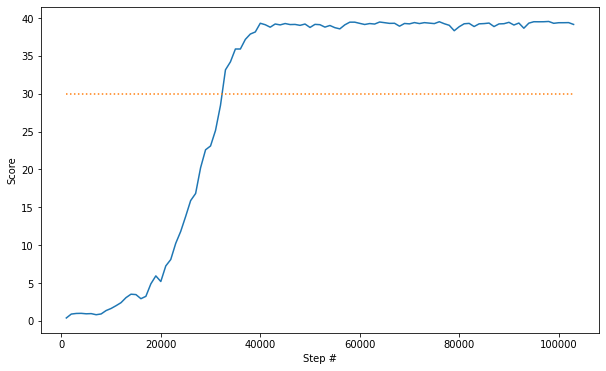

In [14]:
def plot_scores():
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111)
    
    plt.plot(*zip(*scores))
    plt.plot(
        list(map(lambda pair: pair[0], scores)),
        [30] * len(scores),
        ":"
    )

    plt.ylabel('Score')
    plt.xlabel('Step #')
    plt.show()


plot_scores()

As you can see, the agent consistently achieves a score higher than 30 within the first 100 episodes.

Finally, runing the following cell would simulate one run to demonstrate how the trained agent performs:

In [18]:
agent.run_episode()

39.602003537118435

## Next steps

Plappert et al. (2017) suggested using parameter space noisy for more effective exploration, which would be interesting to try. We did try using the similar technique of using NoisyNet proposed by Fortunato et al. (2017) though, but it didn't seem to help

We also didn't get to try incorporating the **distributional critic** extension as in D4PG, which could provide further performance improvement.

## References

- Lillicrap, T. P. et al. (2015) ‘Continuous control with deep reinforcement learning’. Available at: http://arxiv.org/abs/1509.02971
- Fujimoto, S., van Hoof, H. and Meger, D. (2018) ‘Addressing Function Approximation Error in Actor-Critic Methods’. Available at: https://arxiv.org/abs/1802.09477
- Barth-Maron, G. et al. (2018) ‘Distributed Distributional Deterministic Policy Gradients’. Available at: https://arxiv.org/abs/1804.08617
- Schaul, T. et al. (2015) ‘Prioritized Experience Replay’. Available at: http://arxiv.org/abs/1511.05952
- Plappert, M., Houthooft, R., Dhariwal, P., Sidor, S., Chen, R. Y., Chen, X., Asfour, T., Abbeel, P., & Andrychowicz, M. (2017). Parameter Space Noise for Exploration. https://arxiv.org/abs/1706.01905
- Fortunato, M., Azar, M. G., Piot, B., Menick, J., Osband, I., Graves, A., Mnih, V., Munos, R., Hassabis, D., Pietquin, O., Blundell, C., & Legg, S. (2017). Noisy Networks for Exploration. https://arxiv.org/abs/1706.10295